# Simulations to support SVD analyses

In [767]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sys
seaborn.set(font_scale=1.5,style='ticks')


sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/mecll/")
from SVD_analysis import *

# Ok so what you want to do is simulate data with some number of PCs for task space and for physical space and then add these together. Then take an n-dimensional noise distribution and add this to the mean of the data

In [768]:
n_neurons = 100
num_space_pcs = 2
num_task_pcs = 3
num_ports = 9
n_noise_components = 5

order1 = np.random.permutation(np.arange(num_ports))
order2 = np.random.permutation(np.arange(num_ports))
#task_W
task_W = np.random.normal(size=(n_neurons,num_task_pcs))
#space_W
space_W = np.random.normal(size=(n_neurons,num_space_pcs))

noise_W = np.random.normal(size=(n_neurons,n_noise_components))



In [769]:
np.linalg.matrix_rank(space_W)

2

In [782]:
def get_params(n_neurons=100, num_space_pcs=3,num_task_pcs=3, num_ports=9,n_noise_components=5):
    """ Generate parameters """
    order1 = np.random.permutation(np.arange(num_ports))
    order2 = np.random.permutation(np.arange(num_ports))
    #task_W
    task_W = np.random.normal(size=(n_neurons,num_task_pcs))
    task_W2 = task_W
    #task_W2 = np.random.normal(size=(n_neurons,num_task_pcs))
    #space_W
    space_W = np.random.normal(size=(n_neurons,num_space_pcs))
    noise_W = np.random.normal(size=(n_neurons,n_noise_components))

    spatial_state = np.random.normal(size=(num_space_pcs,num_ports))
    task_state = np.random.normal(size=(num_task_pcs,num_ports))
    return space_W,spatial_state,task_W,task_W2,task_state,order1,order2,noise_W


In [783]:
def generate_activity(space_W,spatial_state,task_W,task_W2,task_state,order1,order2,noise_W):
    """ Generate activity from parameters"""
    
    n_neurons = task_W.shape[0]; n_ports = task_state.shape[1]
    activity_task1 = space_W@spatial_state + task_W@task_state[:,order1]  + np.random.normal(size=(n_neurons,num_ports))

    activity_task1_prime = space_W@spatial_state + task_W@task_state[:,order1] + np.random.normal(size=activity_task1.shape)

    activity_task2 = space_W@spatial_state + task_W2@task_state[:,order2]  + np.random.normal(size=activity_task1.shape)
    activity_task2_prime = space_W@spatial_state + task_W2@task_state[:,order2] + np.random.normal(size=activity_task1.shape)
    return activity_task1, activity_task1_prime, activity_task2, activity_task2_prime

In [784]:
def remove_space(activity_task1,activity_task1_prime,activity_task2,activity_task2_prime):
    
    spatial_component = np.mean(np.dstack((activity_task1_prime + activity_task2)),axis=2)
    activity_task1 = activity_task1 - spatial_component
    activity_task1_prime = activity_task1_prime - spatial_component
    activity_task2 = activity_task2 - spatial_component
    return activity_task1,activity_task1_prime,activity_task2,activity_task2_prime

In [785]:
params = get_params()
activity_task1, activity_task1_prime, activity_task2, activity_task2_prime = generate_activity(*params)
activity_task1_prime_prime = activity_task1 + np.random.normal(size=(n_neurons,num_ports))


In [786]:
REMOVE_SPACE = True
if REMOVE_SPACE:
    print('removing spatial responses...')
    spatial_component = np.mean(np.dstack([activity_task1,activity_task2_prime]),axis=2)
    activity_task1 = activity_task1 - spatial_component
    activity_task1_prime = activity_task1_prime - spatial_component
    activity_task2 = activity_task2 - spatial_component


removing spatial responses...


In [787]:
np.corrcoef(activity_task1_prime.flatten(),activity_task2.flatten())

array([[ 1.        , -0.37926685],
       [-0.37926685,  1.        ]])

In [788]:
    
activity_task1 = activity_task1 - np.mean(activity_task1,axis=1)[:,None]
activity_task1_prime = activity_task1_prime - np.mean(activity_task1_prime,axis=1)[:,None]
activity_task2 = activity_task2 - np.mean(activity_task2,axis=1)[:,None]
#activity_task1 = activity_task1 - np.mean(activity_task1,axis=1)[:,None]

In [789]:
tmp = variance_explained_U(activity_task1,activity_task1_prime,activity_task2)

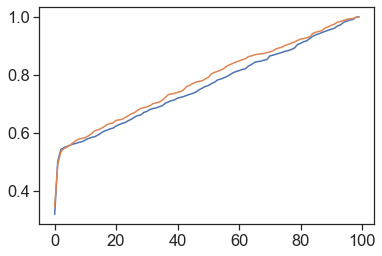

In [790]:
plt.plot(np.cumsum(tmp,axis=1)[0])
plt.plot(np.cumsum(tmp,axis=1)[1])
#plt.xlim(0,50)

# What is the SVD measure?


What you want to look at is whether there are common cellular ensembles that are active. If there are

In [796]:
all_tmp = []
for _ in range(1000):
    params = get_params()
    activity_task1, activity_task1_prime, activity_task2, activity_task2_prime = generate_activity(*params)
    activity_task1_prime_prime = activity_task1 + np.random.normal(size=(n_neurons,num_ports))

    
    REMOVE_SPACE = True
    if REMOVE_SPACE:
        #print('removing spatial responses...')
        spatial_component = np.mean(np.dstack([activity_task1,activity_task2_prime]),axis=2)
        activity_task1 = activity_task1 - spatial_component
        activity_task1_prime = activity_task1_prime - spatial_component
        activity_task2 = activity_task2 - spatial_component



    activity_task1 = activity_task1 - np.mean(activity_task1,axis=1)[:,None]
    activity_task1_prime = activity_task1_prime - np.mean(activity_task1_prime,axis=1)[:,None]
    activity_task2 = activity_task2 - np.mean(activity_task2,axis=1)[:,None]
    #activity_task1 = activity_task1 - np.mean(activity_task1,axis=1)[:,None]
    
    tmp = variance_explained_U(activity_task1,activity_task1_prime,activity_task2)
    all_tmp.append(tmp)

In [797]:
tmp = np.mean(all_tmp,axis=0)


In [800]:
np.max(np.cumsum(tmp,axis=1)[0]-np.cumsum(tmp,axis=1)[1])

8.821844866357953e-05

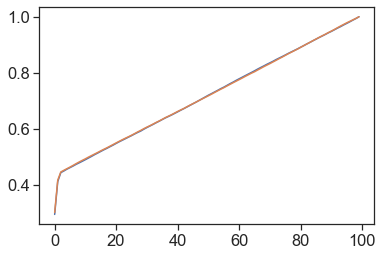

In [793]:
plt.plot(np.cumsum(tmp,axis=1)[0])
plt.plot(np.cumsum(tmp,axis=1)[1])
#plt.xlim(0,50)